# Create Model Data Splits

In [262]:
import pickle
import numpy as np
import re
import pandas as pd

def create_dfs(split):
    with open(f"data/{split}.pkl", 'rb') as fid:
        df = pickle.load(fid)
        
    labels = np.load(f"data/label/{split}_label_fn_labels.npz")
    labels_data = labels["data"]
    label_fn_names = [re.match('.*Function (.+), .*', lf).group(1) for lf in  labels["label_fns"]]
    tmp = pd.DataFrame(labels_data, columns=label_fn_names)
    
    df = pd.concat([df.reset_index(), tmp.reset_index()], axis=1)
    
    label_major = np.load(f"data/label/{split}_majority_vote_labels.npz")
    label_major = label_major['data']
    df['majority_vote'] = label_major
    
    label_model = np.load(f"data/label/{split}_label_model_labels.npz")
    label_model = label_model['data']
    label_model = [list(label_model[i, :]) for i in range(label_model.shape[0])]
    df['prob_labels'] = label_model
    
    # filter out invalid sentences that are too long and likely not real sentences (more than 10 terms)
    df['location'] = list(zip(df['chapter'], df['section'], df['sentence']))
    invalid = \
        df \
        .query('majority_vote >= 0') \
        .groupby(['chapter', 'section', 'sentence']) \
        .majority_vote \
        .agg(count='count', hyponym=lambda x: sum(x) > 0) \
        .reset_index() \
        .query('count > 140') \
        .assign(location=lambda df: list(zip(df['chapter'], df['section'], df['sentence'])))
    df = df[~df.location.isin(invalid.location)]
                
    # filter out openstax bio learning goal sentences
    df = df[~((df.textbook == 'OpenStax Biology 2e') & (df.sentence == 1))]
    
    return df 
    
dev = create_dfs('dev')
test = create_dfs('test')
train = create_dfs('train')

In [263]:
print(train.shape)

(679516, 27)


In [264]:
# filter out data points without any labels
train = train[train.majority_vote >= 0]

In [265]:
train.shape

(559375, 27)

In [266]:
train['term_pair'] = list(zip(train['term1'], train['term2']))
dev['term_pair'] = list(zip(dev['term1'], dev['term2']))
test['term_pair'] = list(zip(test['term1'], test['term2']))

In [267]:
# filter out dev set overlap
train = train[~train.term_pair.isin(dev.term_pair)]

In [268]:
train.shape

(479996, 28)

In [269]:
# filter out test set overlap
train = train[~train.term_pair.isin(test.term_pair)]

In [270]:
train.shape

(449461, 28)

In [313]:
# create a debugging set with 10 sentences with a taxonomy relation and 10 without
sent_check = train.groupby(['chapter', 'section', 'sentence']).agg({'majority_vote': lambda x: sum(x) > 0}).reset_index()
pos_exs = sent_check[sent_check.majority_vote].sample(5)
neg_exs = sent_check[~sent_check.majority_vote].sample(4)
pos_exs['location'] = list(zip(pos_exs['chapter'], pos_exs['section'], pos_exs['sentence']))
neg_exs['location'] = list(zip(neg_exs['chapter'], neg_exs['section'], neg_exs['sentence']))
debug = pd.concat(
    [train[train.location.isin(pos_exs.location)], 
     train[train.location.isin(neg_exs.location)]], 
    axis=0)
debug.to_pickle('data/model_data/debug.pkl')
debug.shape

(131, 28)

In [314]:
debug.head(16)

,index,textbook,chapter,section,sentence,text,tokens,term1,term1_location,term2,...,appo_pattern,other_pattern,knownas_pattern,term_pos,term_subset,kb_bio101_ds,majority_vote,prob_labels,location,term_pair
13388,13388,Life Biology,2,0,102,van der Waals forces occur in polar and nonpolar molecules.,"[van, der, Waals, forces, occur, in, polar, and, nonpolar, molecules, .]",polar substance,"(6, 7)",nonpolar substance,...,-1,-1,-1,-1,0,-1,0,"[0.49110983137302394, 0.508890168626976]","(2, 0, 102)","(polar substance, nonpolar substance)"
13389,13389,Life Biology,2,0,102,van der Waals forces occur in polar and nonpolar molecules.,"[van, der, Waals, forces, occur, in, polar, and, nonpolar, molecules, .]",nonpolar substance,"(8, 9)",polar substance,...,-1,-1,-1,-1,1,-1,1,"[0.14931720335598211, 0.8506827966440179]","(2, 0, 102)","(nonpolar substance, polar substance)"
13398,13398,Life Biology,2,0,102,van der Waals forces occur in polar and nonpolar molecules.,"[van, der, Waals, forces, occur, in, polar, and, nonpolar, molecules, .]",molecule,"(9, 10)",force,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(2, 0, 102)","(molecule, force)"
13399,13399,Life Biology,2,0,102,van der Waals forces occur in polar and nonpolar molecules.,"[van, der, Waals, forces, occur, in, polar, and, nonpolar, molecules, .]",force,"(3, 4)",molecule,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(2, 0, 102)","(force, molecule)"
15714,15714,Life Biology,2,0,102,The ionization of strong acids and bases in water is virtually irreversible.,"[The, ionization, of, strong, acids, and, bases, in, water, is, virtually, irreversible, .]",strong acid,"(3, 5)",water,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(2, 0, 102)","(strong acid, water)"
15715,15715,Life Biology,2,0,102,The ionization of strong acids and bases in water is virtually irreversible.,"[The, ionization, of, strong, acids, and, bases, in, water, is, virtually, irreversible, .]",water,"(8, 9)",strong acid,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(2, 0, 102)","(water, strong acid)"
16042,16042,Life Biology,2,0,145,"A buffer is a mixture of a weak acid and its corresponding base, or a weak base and its corresponding acid.","[A, buffer, is, a, mixture, of, a, weak, acid, and, its, corresponding, base, ,, or, a, weak, base, and, its, corresponding, acid, .]",weak base,"(16, 18)",weak acid,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(2, 0, 145)","(weak base, weak acid)"
16043,16043,Life Biology,2,0,145,"A buffer is a mixture of a weak acid and its corresponding base, or a weak base and its corresponding acid.","[A, buffer, is, a, mixture, of, a, weak, acid, and, its, corresponding, base, ,, or, a, weak, base, and, its, corresponding, acid, .]",weak acid,"(7, 9)",weak base,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(2, 0, 145)","(weak acid, weak base)"
16044,16044,Life Biology,2,0,145,"A buffer is a mixture of a weak acid and its corresponding base, or a weak base and its corresponding acid.","[A, buffer, is, a, mixture, of, a, weak, acid, and, its, corresponding, base, ,, or, a, weak, base, and, its, corresponding, acid, .]",weak base,"(16, 18)",mixture,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(2, 0, 145)","(weak base, mixture)"
16045,16045,Life Biology,2,0,145,"A buffer is a mixture of a weak acid and its corresponding base, or a weak base and its corresponding acid.","[A, buffer, is, a, mixture, of, a, weak, acid, and, its, corresponding, base, ,, or, a, weak, base, and, its, corresponding, acid, .]",mixture,"(4, 5)",weak base,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(2, 0, 145)","(mixture, weak base)"


In [272]:
train.to_pickle('data/model_data/train.pkl')
dev.to_pickle('data/model_data/dev.pkl')
test.to_pickle('data/model_data/test.pkl')

In [311]:
debug.head()

,index,textbook,chapter,section,sentence,text,tokens,term1,term1_location,term2,...,appo_pattern,other_pattern,knownas_pattern,term_pos,term_subset,kb_bio101_ds,majority_vote,prob_labels,location,term_pair
3440,3440,Life Biology,1,0,144,Much of biology is based on comparisons among species.,"[Much, of, biology, is, based, on, comparisons, among, species, .]",specie,"(8, 9)",biology,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(1, 0, 144)","(specie, biology)"
3441,3441,Life Biology,1,0,144,Much of biology is based on comparisons among species.,"[Much, of, biology, is, based, on, comparisons, among, species, .]",biology,"(2, 3)",specie,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(1, 0, 144)","(biology, specie)"
3442,3442,Life Biology,1,0,144,Much of biology is based on comparisons among species.,"[Much, of, biology, is, based, on, comparisons, among, species, .]",specie,"(8, 9)",base,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(1, 0, 144)","(specie, base)"
3443,3443,Life Biology,1,0,144,Much of biology is based on comparisons among species.,"[Much, of, biology, is, based, on, comparisons, among, species, .]",base,"(4, 5)",specie,...,-1,-1,-1,0,-1,0,0,"[0.7567416209846708, 0.24325837901532915]","(1, 0, 144)","(base, specie)"
3444,3444,Life Biology,1,0,144,Much of biology is based on comparisons among species.,"[Much, of, biology, is, based, on, comparisons, among, species, .]",biology,"(2, 3)",base,...,-1,-1,-1,-1,-1,0,0,"[0.6891327760299161, 0.310867223970084]","(1, 0, 144)","(biology, base)"


# Data Statistics

- Overall imbalance (word pairs and sentence level)
- How many sentences?
- How many term pairs / sentence?
- How many additional word pairs in sentences with a hyponym relation?

In [273]:
import seaborn as sns
import matplotlib.pyplot as plt

## Overall Term Pair Imbalance

In [274]:
train \
    .query('majority_vote >= 0') \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,0,445849,0.991964
1,1,3612,0.008036


In [275]:
dev \
    .query('majority_vote >= 0') \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,0,33489,0.991121
1,1,300,0.008879


In [276]:
test \
    .query('majority_vote >= 0') \
    .groupby('majority_vote') \
    .majority_vote \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,majority_vote,count,prop
0,0,12135,0.992963
1,1,86,0.007037


## Sentence Counts

In [277]:
len(train.groupby(['chapter', 'section', 'sentence']))

29652

In [278]:
len(dev.groupby(['chapter', 'section', 'sentence']))

1665

In [279]:
len(test.groupby(['chapter', 'section', 'sentence']))

886

## Positive vs. Negative Sentence Balance

In [280]:
train \
    .query('majority_vote >= 0') \
    .groupby(['chapter', 'section', 'sentence']) \
    .majority_vote \
    .agg(pos=lambda x: sum(x) > 0) \
    .reset_index() \
    .groupby('pos') \
    .sentence \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,pos,count,prop
0,False,26744,0.901929
1,True,2908,0.098071


In [281]:
dev \
    .query('majority_vote >= 0') \
    .groupby(['chapter', 'section', 'sentence']) \
    .majority_vote \
    .agg(pos=lambda x: sum(x) > 0) \
    .reset_index() \
    .groupby('pos') \
    .sentence \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,pos,count,prop
0,False,1376,0.850433
1,True,242,0.149567


In [282]:
test \
    .query('majority_vote >= 0') \
    .groupby(['chapter', 'section', 'sentence']) \
    .majority_vote \
    .agg(pos=lambda x: sum(x) > 0) \
    .reset_index() \
    .groupby('pos') \
    .sentence \
    .agg(count='count') \
    .reset_index() \
    .assign(prop=lambda df: df['count'] / df['count'].sum())

,pos,count,prop
0,False,771,0.914591
1,True,72,0.085409


# Sentence Term Pair Count Distributions

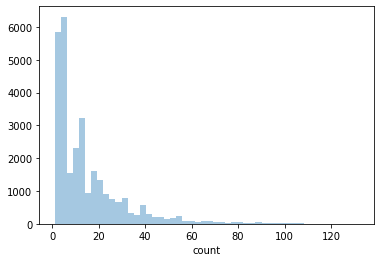

In [288]:
tmp = \
    train \
    .query('majority_vote >= 0') \
    .groupby(['chapter', 'section', 'sentence']) \
    .majority_vote \
    .agg(count='count', hyponym=lambda x: sum(x) > 0) \
    .reset_index() \
    .sort_values('count', ascending=False)
sns.distplot(tmp['count'], norm_hist=False, kde=False)

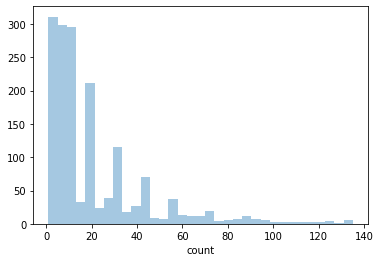

In [296]:
tmp = \
    dev \
    .query('majority_vote >= 0') \
    .groupby(['chapter', 'section', 'sentence']) \
    .majority_vote \
    .agg(count='count', hyponym=lambda x: sum(x) > 0) \
    .reset_index() \
    .sort_values('count', ascending=False)
sns.distplot(tmp['count'], norm_hist=False, kde=False)

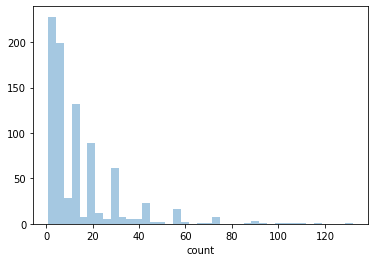

In [297]:
tmp = \
    test \
    .query('majority_vote >= 0') \
    .groupby(['chapter', 'section', 'sentence']) \
    .majority_vote \
    .agg(count='count', hyponym=lambda x: sum(x) > 0) \
    .reset_index() \
    .sort_values('count', ascending=False)
sns.distplot(tmp['count'], norm_hist=False, kde=False)

## Unique Term Pairs

In [293]:
train \
    .query('majority_vote >= 0') \
    .groupby(['majority_vote']) \
    .term_pair \
    .agg(num='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['num'] / df['num'].sum())

,majority_vote,num,prop
0,0,224771,0.992161
1,1,1776,0.007839


In [294]:
dev \
    .query('majority_vote >= 0') \
    .groupby(['majority_vote']) \
    .term_pair \
    .agg(num='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['num'] / df['num'].sum())

,majority_vote,num,prop
0,0,20846,0.992714
1,1,153,0.007286


In [295]:
test \
    .query('majority_vote >= 0') \
    .groupby(['majority_vote']) \
    .term_pair \
    .agg(num='nunique') \
    .reset_index() \
    .assign(prop=lambda df: df['num'] / df['num'].sum())

,majority_vote,num,prop
0,0,7899,0.992836
1,1,57,0.007164


## Frequency of Term Pairs

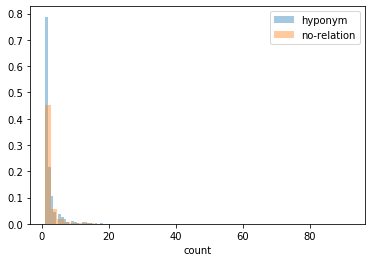

In [306]:
tmp = \
    train \
    .query('majority_vote >= 0') \
    .groupby(['term_pair']) \
    .majority_vote \
    .agg(count='count', hyponym=lambda x: sum(x) > 0) \
    .reset_index()
plt.figure()
sns.distplot(tmp.loc[tmp.hyponym, 'count'], norm_hist=True, kde=False)
sns.distplot(tmp.loc[~tmp.hyponym, 'count'], norm_hist=True, kde=False)
plt.legend(['hyponym', 'no-relation'])
plt.show()

# Explore

In [307]:
pd.set_option('display.max_colwidth', -1)
dev[dev.majority_vote == 1].sample(10)

,index,textbook,chapter,section,sentence,text,tokens,term1,term1_location,term2,...,appo_pattern,other_pattern,knownas_pattern,term_pos,term_subset,kb_bio101_ds,majority_vote,prob_labels,location,term_pair
14251,101573,Life Biology,11,3,12,Throughout G2 the sister chromatids are held together along most of their length by a protein complex called cohesin.,"[Throughout, G2, the, sister, chromatids, are, held, together, along, most, of, their, length, by, a, protein, complex, called, cohesin, .]",cohesin,"(18, 19)",protein complex,...,-1,-1,-1,-1,-1,1,1,"[0.2559022997691878, 0.7440977002308121]","(11, 3, 12)","(cohesin, protein complex)"
8968,42226,Life Biology,5,0,14,"With the theory of endosymbiosis biologists have proposed that some organelles the mitochondria and the plastids arose not by an infolding of the cell membrane but by one cell ingesting (but not digesting) another cell, giving rise to a symbiotic relationship.","[With, the, theory, of, endosymbiosis, biologists, have, proposed, that, some, organelles, , the, mitochondria, and, the, plastids, , arose, not, by, an, infolding, of, the, cell, membrane, but, by, one, cell, ingesting, (, but, not, digesting, ), another, cell, ,, giving, rise, to, a, symbiotic, relationship, .]",plastid,"(16, 17)",organelle,...,-1,-1,-1,-1,-1,1,1,"[0.2559022997691878, 0.7440977002308121]","(5, 0, 14)","(plastid, organelle)"
2763,36021,Life Biology,5,0,29,Cellular structures found in plant but not animal cells include the cell wall and the chloroplasts.,"[Cellular, structures, found, in, plant, but, not, animal, cells, include, the, cell, wall, and, the, chloroplasts, .]",cell wall,"(11, 13)",cellular structure,...,-1,-1,-1,-1,-1,1,1,"[0.2559022997691878, 0.7440977002308121]","(5, 0, 29)","(cell wall, cellular structure)"
10688,43946,Life Biology,5,y,101,Create a graph or table to predict the results of an experiment in which researchers follow the fates of two proteins after they are made on ribosomes in the rough ER: a secretory protein destined to be secreted by the cell and a peroxidase destined for the peroxisome.,"[Create, a, graph, or, table, to, predict, the, results, of, an, experiment, in, which, researchers, follow, the, fates, of, two, proteins, after, they, are, made, on, ribosomes, in, the, rough, ER, :, a, secretory, protein, destined, to, be, secreted, by, the, cell, and, a, peroxidase, destined, for, the, peroxisome, .]",secretory protein,"(33, 35)",protein,...,-1,-1,-1,-1,1,1,1,"[0.056928661116906296, 0.9430713388830937]","(5, y, 101)","(secretory protein, protein)"
14684,102006,Life Biology,11,0,1,The spindle apparatus (also called the mitotic spindle or simply the spindle) is a dynamic microtubule structure that moves sister chromatids apart during mitosis.,"[The, spindle, apparatus, (, also, called, the, mitotic, spindle, or, simply, the, spindle, ), is, a, dynamic, microtubule, structure, that, moves, sister, chromatids, apart, during, mitosis, .]",mitotic spindle,"(7, 9)",spindle,...,-1,-1,-1,-1,1,1,1,"[0.056928661116906296, 0.9430713388830937]","(11, 0, 1)","(mitotic spindle, spindle)"
30923,35625,OpenStax Biology 2e,4,6,30,"They bear tension, thus maintaining the cell's shape, and anchor the nucleus and other organelles in place.","[They, bear, tension, ,, thus, maintaining, the, cell, 's, shape, ,, and, anchor, the, nucleus, and, other, organelles, in, place, .]",nucleus,"(14, 15)",organelle,...,-1,-1,-1,-1,-1,1,1,"[0.2559022997691878, 0.7440977002308121]","(4, 6, 30)","(nucleus, organelle)"
30977,35679,OpenStax Biology 2e,4,6,36,"Polymerized dimers of α-tubulin and β-tubulin, two globular proteins, comprise the microtubule's walls ( Figure 4.25 ).","[Polymerized, dimers, of, α, -, tubulin, and, β, -, tubulin, ,, two, globular, proteins, ,, comprise, the, microtubule, 's, walls, (, Figure, 4.25, ), .]",tubulin,"(9, 10)",globular protein,...,-1,-1,-1,-1,-1,1,1,"[0.2559022997691878, 0.7440977002308121]","(4, 6, 36)","(tubulin, globular protein)"
11208,98530,Life Bi

# Fit

In [38]:
pos = train[train.majority_vote > 0]
pos.shape

(7592, 27)

In [40]:
neg = train[train.majority_vote == 0].sample(frac=.1)
neg.shape

(48116, 27)

In [41]:
reduced_train = pd.concat([pos, neg], axis=0)
reduced_train.shape

(55708, 27)

In [74]:
%load_ext autoreload
%autoreload 2
from tf_model import get_model, get_feature_arrays

model = get_model()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

X_train = get_feature_arrays(reduced_train)
X_dev = get_feature_arrays(dev)
batch_size = 64

In [43]:
from sklearn.utils import class_weight
y_train = reduced_train['majority_vote']
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}
class_weights

{0: 0.38592845068861364, 1: 4.885381040077172, 2: 4.898267827310296}

In [75]:
y_train = np.array([l for l in reduced_train['prob_labels']])
y_train = np.array(reduced_train['majority_vote'])
model.fit(X_train, y_train, batch_size=batch_size, epochs=10)

Epoch 1/10
55708/55708 [==============================] - 112s 2ms/sample - loss: 0.4930
Epoch 2/10
55708/55708 [==============================] - 101s 2ms/sample - loss: 0.4613
Epoch 3/10
55708/55708 [==============================] - 102s 2ms/sample - loss: 0.4377
Epoch 4/10
55708/55708 [==============================] - 102s 2ms/sample - loss: 0.4170
Epoch 5/10
55708/55708 [==============================] - 100s 2ms/sample - loss: 0.3958
Epoch 6/10
55708/55708 [==============================] - 100s 2ms/sample - loss: 0.3776
Epoch 7/10
55708/55708 [==============================] - 102s 2ms/sample - loss: 0.3600
Epoch 8/10
55708/55708 [==============================] - 102s 2ms/sample - loss: 0.3429
Epoch 9/10
55708/55708 [==============================] - 103s 2ms/sample - loss: 0.3254
Epoch 10/10
55708/55708 [==============================] - 104s 2ms/sample - loss: 0.3097


In [76]:
from snorkel.utils import probs_to_preds
probs_dev = model.predict(X_dev)
pred_dev = probs_to_preds(probs_dev)
dev['predictions'] = pred_dev

In [85]:
pd.set_option('display.max_colwidth', -1)
dev[(dev.predictions == 2) & (dev.majority_vote == 1)].count()

index                 26
textbook              26
chapter               26
section               26
sentence              26
text                  26
tokens                26
term1                 26
term1_location        26
term2                 26
term2_location        26
filter                26
index                 26
isa_pattern           26
suchas_pattern        26
including_pattern     26
called_pattern        26
especially_pattern    26
appo_pattern          26
other_pattern         26
knownas_pattern       26
term_pos              26
term_subset           26
kb_bio101_ds          26
majority_vote         26
prob_labels           26
term_pair             26
predictions           26
dtype: int64

In [27]:
d

,index,textbook,chapter,section,sentence,text,tokens,term1,term1_location,term2,...,called_pattern,especially_pattern,appo_pattern,other_pattern,knownas_pattern,term_pos,term_subset,kb_bio101_ds,prob_labels,term_pair
majority_vote,,,,,,,,,,,,,,,,,,,,,
0,481160,481160,481160,481160,481160,481160,481160,481160,481160,481160,...,481160,481160,481160,481160,481160,481160,481160,481160,481160,481160
1,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801,...,3801,3801,3801,3801,3801,3801,3801,3801,3801,3801
2,3791,3791,3791,3791,3791,3791,3791,3791,3791,3791,...,3791,3791,3791,3791,3791,3791,3791,3791,3791,3791


In [31]:
7600 / (480000 + 7600)

0.015586546349466776

In [32]:
1 / .0155

64.51612903225806